# VAE pour MNIST
Voici une première implémentation d'un VAE.

Nous utilisons le jeu de données MNIST avec les chiffres en niveau de gris.

Notre VAE apprend donc la paramétrisation de la loi latente des images.

Cela permet de générer des images de chiffres à partir de vecteurs aléatoirs de la taille de l'espace latent.

In [3]:
import matplotlib.pyplot as plt
import pandas as ps 
from sklearn.metrics import mean_squared_error

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [4]:
# Hyperparamètres
latent_dim = 20
batch_size = 64
epochs = 25
learning_rate = 1e-3

# Préparation des données (MNIST)
transform = transforms.Compose([transforms.ToTensor()])
train_loader = DataLoader(datasets.MNIST('./data', train=True, download=True, transform=transform), batch_size=batch_size, shuffle=True)


In [5]:
# Définition du VAE
class VAE(nn.Module):
    def __init__(self, input_dim=28*28, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()
        # Encodeur
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Décodeur
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28*28))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Définition de la fonction de perte
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


In [4]:
# Entraînement du modèle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {train_loss / len(train_loader.dataset)}")


Epoch 1, Loss: 147.68985592447916
Epoch 2, Loss: 115.87621608072917
Epoch 3, Loss: 111.38059779052735
Epoch 4, Loss: 109.3455450764974
Epoch 5, Loss: 108.1627238647461
Epoch 6, Loss: 107.27970759277343
Epoch 7, Loss: 106.7030090250651
Epoch 8, Loss: 106.17808907877604
Epoch 9, Loss: 105.77797035725912
Epoch 10, Loss: 105.47695483805339
Epoch 11, Loss: 105.16022496337891


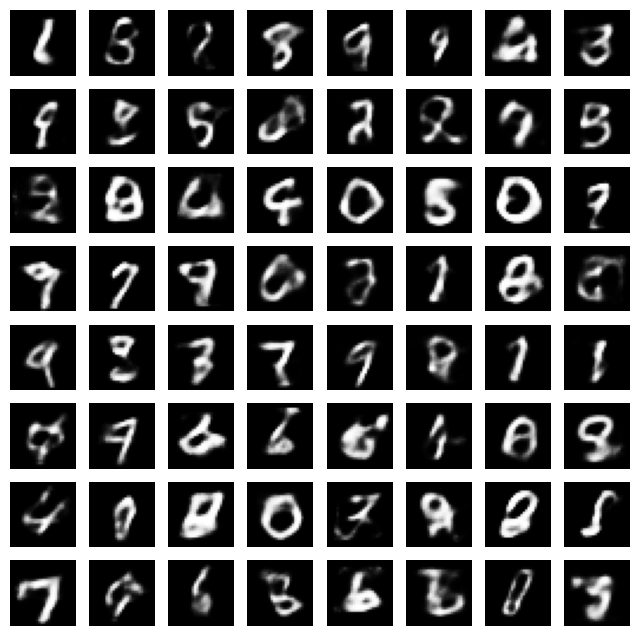

In [5]:
# Génération d'images
import matplotlib.pyplot as plt
model.eval()
with torch.no_grad():
    z = torch.randn(64, latent_dim).to(device)
    samples = model.decode(z).cpu().numpy()

fig, axes = plt.subplots(8, 8, figsize=(8, 8))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(samples[i].reshape(28, 28), cmap="gray")
    ax.axis("off")
plt.show()


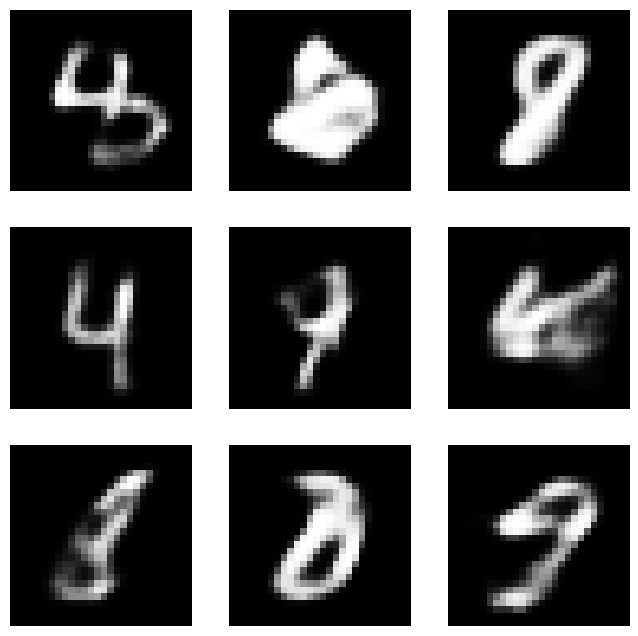

In [7]:
# Génération d'images
import matplotlib.pyplot as plt
model.eval()
with torch.no_grad():
    z = torch.randn(9, latent_dim).to(device)
    samples = model.decode(z).cpu().numpy()

fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(samples[i].reshape(28, 28), cmap="gray")
    ax.axis("off")
plt.show()
